# V.14
- 이미지의 네모 박스를 제거해서 학습

In [1]:
import pandas as pd
import numpy as np
import os
import time
import random
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cv2

import timm
import torch
import albumentations as A
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from albumentations.core.transforms_interface import ImageOnlyTransform
from augraphy import *

from sklearn.metrics import accuracy_score, f1_score

import wandb

In [3]:
wandb.login(key='')
run = wandb.init(project='CV_contest_V14', name='training2')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [4]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
device

device(type='cuda')

In [19]:
'''
train_df = pd.read_csv('/data/ephemeral/home/data/train.csv')
train_df = train_df[(train_df['target']==3) | (train_df['target']==4) | (train_df['target']==7) | (train_df['target']==14)]
train_df.reset_index(drop=True, inplace=True)

mapping = {3:0, 4:1, 7:2, 14:3}
train_df['target'] = train_df['target'].map(mapping)

train_df.to_csv('v_14_train.csv')
'''

In [7]:
train_df = pd.read_csv('/data/ephemeral/home/data/v_14_train.csv')
train_df

,Unnamed: 0,ID,target
0,0,009235e4c9c07af5.jpg,1
1,1,012913977fd1d980.jpg,3
2,2,0250ee8107091ade.jpg,2
3,3,02dad82a9420ae86.jpg,2
4,4,03084c1b03921a99.jpg,2
...,...,...,...
345,345,fe30845b79d1d42f.jpg,2
346,346,fe73481aadfbec34.jpg,0
347,347,fe9683317086dbab.jpg,0
348,348,fed9e9ec4a77bc06.jpg,1


# CustomDataset

In [8]:
class customdataset(torch.utils.data.Dataset):
    def __init__(self, csv, path, transforms):
        super().__init__()
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx][1], self.df[idx][2]
        img = np.array(Image.open(os.path.join(self.path, name)))
        img = self.transforms(img)
    
        return img, target

In [9]:
class RandomPadding:
    def __init__(self, padding_range=(0, 50), fill=0):
        self.padding_range = padding_range
        self.fill = fill

    def __call__(self, image):
        # 각 방향에 대해 랜덤한 패딩 값 생성
        pad_top = random.randint(*self.padding_range)
        pad_bottom = random.randint(*self.padding_range)
        pad_left = random.randint(*self.padding_range)
        pad_right = random.randint(*self.padding_range)
        
        # 패딩 추가
        padding = (pad_left, pad_top, pad_right, pad_bottom)
        return T.functional.pad(image, padding, fill=self.fill)

In [14]:
aug_transforms = T.Compose([
    T.ToTensor(),
    T.RandomRotation(180),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    RandomPadding(padding_range=(10, 20), fill=50),  # 랜덤 패딩 추가
    T.RandomResizedCrop(size=(500,500), scale=(0.5, 1.0)),
])

simple_transforms = T.Compose([
    T.ToTensor(),
    T.RandomRotation(180),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.Resize((500, 500))
])

origin_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((500, 500))
    ])


aug_dataset_1 = customdataset('/data/ephemeral/home/data/v_14_train.csv', '/data/ephemeral/home/data/Augmentation/mask_deleted_augraphy/augmented1', transforms=aug_transforms)
aug_dataset_2 = customdataset('/data/ephemeral/home/data/v_14_train.csv', '/data/ephemeral/home/data/Augmentation/mask_deleted_augraphy/augmented2', transforms=aug_transforms)
aug_dataset_3 = customdataset('/data/ephemeral/home/data/v_14_train.csv', '/data/ephemeral/home/data/Augmentation/mask_deleted_augraphy/augmented3', transforms=aug_transforms)
aug_dataset_4 = customdataset('/data/ephemeral/home/data/v_14_train.csv', '/data/ephemeral/home/data/Augmentation/mask_deleted_augraphy/augmented4', transforms=aug_transforms)

simple_aug_dataset_1 = customdataset('/data/ephemeral/home/data/v_14_train.csv', '/data/ephemeral/home/data/mask_deleted_3_4_7_14', transforms=simple_transforms)

origin_dataset_1 = customdataset('/data/ephemeral/home/data/v_14_train.csv', '/data/ephemeral/home/data/train/', transforms=origin_transforms)

In [15]:
total_dataset = torch.utils.data.ConcatDataset([aug_dataset_1, aug_dataset_2, aug_dataset_3, aug_dataset_4,

                                                simple_aug_dataset_1,

                                                origin_dataset_1])

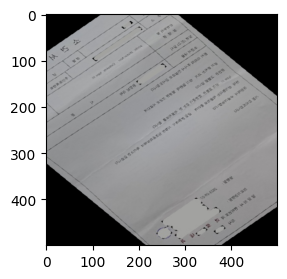

In [16]:
plt.figure(figsize=(3, 3))
plt.imshow(total_dataset[1500][0].permute(1, 2, 0))
plt.show()

In [17]:
total_num = len(total_dataset)
train_num, valid_num = int(total_num*0.8), int(total_num*0.2)

train_dataset, valid_dataset = torch.utils.data.random_split(total_dataset, [train_num, valid_num])

In [18]:
print(train_num, valid_num)

1680 420


In [19]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=16)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=16)

# 학습

In [20]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evalutaion(model, valid_dataloader, valid_accuracy, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(outputs, 1)
            valid_accuracy += (predicted == labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, num_epochs):
    best_valid_loss = float('inf')
    early_stop_cnt = 0
    valid_max_accuracy = -1

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evalutaion(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        monitoring_values = {'Train Loss': train_loss, 'Valid Loss': valid_loss, 'Train Accuracy': train_accuracy, 'Valid Accuracy': valid_accuracy}
        run.log(monitoring_values, step=epoch)

        if valid_accuracy > valid_max_accuracy:
            valid_max_accuracy = valid_accuracy

        if valid_loss < best_valid_loss:
            torch.save(model.state_dict(), f"/data/ephemeral/home/model/models/model_v14_2_best.pt")
            best_valid_loss = valid_loss
            early_stop_cnt = 0

        else :
            early_stop_cnt += 1

        torch.save(model.state_dict(), f"/data/ephemeral/home/model/models/model_v14_2_last.pt")
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

        if early_stop_cnt >= 30:
            print('Early Stopping')
            break

    return model

In [21]:
list(train_df['target'].unique())

[1, 3, 2, 0]

In [22]:
model = timm.create_model(
    'resnet34',
    pretrained=True,
    num_classes=len(list(train_df['target'].unique()))
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
model = training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, 500)

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [1/500], Train Loss: 1.3134, Train Accuracy: 0.3774 Valid Loss: 1.2617, Valid Accuracy: 0.4333


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [2/500], Train Loss: 1.1529, Train Accuracy: 0.4899 Valid Loss: 1.1915, Valid Accuracy: 0.5238


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [3/500], Train Loss: 0.9955, Train Accuracy: 0.5589 Valid Loss: 1.6620, Valid Accuracy: 0.3833


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [4/500], Train Loss: 0.9121, Train Accuracy: 0.6083 Valid Loss: 1.2728, Valid Accuracy: 0.4929


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [5/500], Train Loss: 0.8217, Train Accuracy: 0.6423 Valid Loss: 1.0319, Valid Accuracy: 0.5595


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [6/500], Train Loss: 0.7346, Train Accuracy: 0.6935 Valid Loss: 1.2013, Valid Accuracy: 0.5190


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [7/500], Train Loss: 0.6822, Train Accuracy: 0.7179 Valid Loss: 1.6726, Valid Accuracy: 0.4238


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [8/500], Train Loss: 0.6116, Train Accuracy: 0.7583 Valid Loss: 2.6280, Valid Accuracy: 0.4095


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [9/500], Train Loss: 0.5771, Train Accuracy: 0.7696 Valid Loss: 1.3576, Valid Accuracy: 0.4714


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [10/500], Train Loss: 0.5270, Train Accuracy: 0.7940 Valid Loss: 0.8964, Valid Accuracy: 0.6429


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [11/500], Train Loss: 0.5077, Train Accuracy: 0.8065 Valid Loss: 1.5777, Valid Accuracy: 0.5929


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [12/500], Train Loss: 0.4442, Train Accuracy: 0.8292 Valid Loss: 0.5767, Valid Accuracy: 0.8048


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [13/500], Train Loss: 0.3484, Train Accuracy: 0.8685 Valid Loss: 0.9569, Valid Accuracy: 0.6214


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [14/500], Train Loss: 0.4003, Train Accuracy: 0.8506 Valid Loss: 0.6034, Valid Accuracy: 0.7500


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [15/500], Train Loss: 0.3211, Train Accuracy: 0.8887 Valid Loss: 1.0071, Valid Accuracy: 0.6786


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [16/500], Train Loss: 0.2825, Train Accuracy: 0.8976 Valid Loss: 0.6049, Valid Accuracy: 0.7690


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [17/500], Train Loss: 0.2765, Train Accuracy: 0.9006 Valid Loss: 0.4331, Valid Accuracy: 0.8310


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [18/500], Train Loss: 0.2447, Train Accuracy: 0.9179 Valid Loss: 0.5660, Valid Accuracy: 0.8119


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [19/500], Train Loss: 0.2343, Train Accuracy: 0.9161 Valid Loss: 0.8739, Valid Accuracy: 0.7095


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [20/500], Train Loss: 0.2032, Train Accuracy: 0.9310 Valid Loss: 0.4654, Valid Accuracy: 0.8190


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [21/500], Train Loss: 0.2125, Train Accuracy: 0.9310 Valid Loss: 0.7652, Valid Accuracy: 0.7262


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [22/500], Train Loss: 0.1967, Train Accuracy: 0.9292 Valid Loss: 0.4557, Valid Accuracy: 0.8238


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [23/500], Train Loss: 0.1527, Train Accuracy: 0.9482 Valid Loss: 0.3944, Valid Accuracy: 0.8429


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [24/500], Train Loss: 0.1531, Train Accuracy: 0.9512 Valid Loss: 0.4338, Valid Accuracy: 0.8524


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [25/500], Train Loss: 0.1462, Train Accuracy: 0.9440 Valid Loss: 0.4288, Valid Accuracy: 0.8786


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [26/500], Train Loss: 0.1533, Train Accuracy: 0.9429 Valid Loss: 1.2389, Valid Accuracy: 0.6738


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [27/500], Train Loss: 0.1646, Train Accuracy: 0.9429 Valid Loss: 0.5149, Valid Accuracy: 0.8143


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [28/500], Train Loss: 0.1495, Train Accuracy: 0.9482 Valid Loss: 0.5262, Valid Accuracy: 0.8119


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [29/500], Train Loss: 0.0838, Train Accuracy: 0.9768 Valid Loss: 0.2934, Valid Accuracy: 0.8952


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [30/500], Train Loss: 0.0980, Train Accuracy: 0.9702 Valid Loss: 0.7096, Valid Accuracy: 0.7690


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [31/500], Train Loss: 0.1063, Train Accuracy: 0.9607 Valid Loss: 0.6949, Valid Accuracy: 0.8143


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [32/500], Train Loss: 0.1176, Train Accuracy: 0.9595 Valid Loss: 0.1825, Valid Accuracy: 0.9357


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [33/500], Train Loss: 0.1595, Train Accuracy: 0.9429 Valid Loss: 0.3917, Valid Accuracy: 0.8762


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [34/500], Train Loss: 0.1409, Train Accuracy: 0.9506 Valid Loss: 0.3248, Valid Accuracy: 0.8810


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [35/500], Train Loss: 0.0993, Train Accuracy: 0.9667 Valid Loss: 0.1760, Valid Accuracy: 0.9333


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [36/500], Train Loss: 0.1258, Train Accuracy: 0.9589 Valid Loss: 0.2429, Valid Accuracy: 0.9381


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [37/500], Train Loss: 0.1108, Train Accuracy: 0.9631 Valid Loss: 0.6475, Valid Accuracy: 0.7690


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [38/500], Train Loss: 0.0656, Train Accuracy: 0.9815 Valid Loss: 0.2811, Valid Accuracy: 0.8952


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [39/500], Train Loss: 0.0677, Train Accuracy: 0.9762 Valid Loss: 0.7077, Valid Accuracy: 0.7595


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [40/500], Train Loss: 0.0951, Train Accuracy: 0.9685 Valid Loss: 0.8377, Valid Accuracy: 0.7405


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [41/500], Train Loss: 0.0930, Train Accuracy: 0.9685 Valid Loss: 0.3483, Valid Accuracy: 0.8929


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [42/500], Train Loss: 0.0715, Train Accuracy: 0.9768 Valid Loss: 0.4125, Valid Accuracy: 0.8714


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [43/500], Train Loss: 0.0642, Train Accuracy: 0.9780 Valid Loss: 0.1740, Valid Accuracy: 0.9357


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [44/500], Train Loss: 0.0650, Train Accuracy: 0.9792 Valid Loss: 0.4683, Valid Accuracy: 0.8357


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [45/500], Train Loss: 0.0643, Train Accuracy: 0.9810 Valid Loss: 0.2307, Valid Accuracy: 0.9071


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [46/500], Train Loss: 0.0599, Train Accuracy: 0.9792 Valid Loss: 0.4045, Valid Accuracy: 0.8857


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [47/500], Train Loss: 0.0835, Train Accuracy: 0.9714 Valid Loss: 3.9198, Valid Accuracy: 0.4762


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [48/500], Train Loss: 0.0932, Train Accuracy: 0.9702 Valid Loss: 0.3568, Valid Accuracy: 0.8786


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [49/500], Train Loss: 0.1122, Train Accuracy: 0.9583 Valid Loss: 0.5764, Valid Accuracy: 0.8333


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [50/500], Train Loss: 0.0972, Train Accuracy: 0.9679 Valid Loss: 0.2419, Valid Accuracy: 0.9143


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [51/500], Train Loss: 0.0579, Train Accuracy: 0.9780 Valid Loss: 0.2198, Valid Accuracy: 0.9238


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [52/500], Train Loss: 0.0510, Train Accuracy: 0.9845 Valid Loss: 0.2342, Valid Accuracy: 0.9214


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [53/500], Train Loss: 0.0357, Train Accuracy: 0.9893 Valid Loss: 0.1111, Valid Accuracy: 0.9429


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [54/500], Train Loss: 0.0608, Train Accuracy: 0.9821 Valid Loss: 0.2345, Valid Accuracy: 0.9071


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [55/500], Train Loss: 0.0391, Train Accuracy: 0.9875 Valid Loss: 0.1685, Valid Accuracy: 0.9310


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [56/500], Train Loss: 0.0614, Train Accuracy: 0.9762 Valid Loss: 0.2094, Valid Accuracy: 0.9286


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [57/500], Train Loss: 0.0577, Train Accuracy: 0.9798 Valid Loss: 0.3504, Valid Accuracy: 0.8619


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [58/500], Train Loss: 0.0818, Train Accuracy: 0.9714 Valid Loss: 0.2969, Valid Accuracy: 0.8976


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [59/500], Train Loss: 0.0793, Train Accuracy: 0.9726 Valid Loss: 0.4791, Valid Accuracy: 0.8048


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [60/500], Train Loss: 0.0573, Train Accuracy: 0.9827 Valid Loss: 0.1273, Valid Accuracy: 0.9548


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [61/500], Train Loss: 0.0685, Train Accuracy: 0.9756 Valid Loss: 0.8903, Valid Accuracy: 0.7476


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [62/500], Train Loss: 0.0719, Train Accuracy: 0.9756 Valid Loss: 0.1736, Valid Accuracy: 0.9357


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [63/500], Train Loss: 0.0559, Train Accuracy: 0.9810 Valid Loss: 0.5429, Valid Accuracy: 0.9048


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [64/500], Train Loss: 0.0704, Train Accuracy: 0.9774 Valid Loss: 0.2247, Valid Accuracy: 0.9405


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [65/500], Train Loss: 0.0783, Train Accuracy: 0.9702 Valid Loss: 0.3435, Valid Accuracy: 0.8643


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [66/500], Train Loss: 0.0442, Train Accuracy: 0.9863 Valid Loss: 0.1684, Valid Accuracy: 0.9571


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [67/500], Train Loss: 0.0667, Train Accuracy: 0.9798 Valid Loss: 0.1889, Valid Accuracy: 0.9286


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [68/500], Train Loss: 0.0777, Train Accuracy: 0.9738 Valid Loss: 0.2548, Valid Accuracy: 0.9024


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [69/500], Train Loss: 0.0698, Train Accuracy: 0.9774 Valid Loss: 0.1727, Valid Accuracy: 0.9405


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [70/500], Train Loss: 0.0480, Train Accuracy: 0.9851 Valid Loss: 0.5088, Valid Accuracy: 0.8476


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [71/500], Train Loss: 0.0691, Train Accuracy: 0.9768 Valid Loss: 0.4478, Valid Accuracy: 0.8405


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [72/500], Train Loss: 0.0523, Train Accuracy: 0.9851 Valid Loss: 0.2400, Valid Accuracy: 0.9048


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [73/500], Train Loss: 0.0268, Train Accuracy: 0.9905 Valid Loss: 0.0851, Valid Accuracy: 0.9738


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [74/500], Train Loss: 0.0501, Train Accuracy: 0.9845 Valid Loss: 0.1947, Valid Accuracy: 0.9214


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [75/500], Train Loss: 0.0454, Train Accuracy: 0.9845 Valid Loss: 0.4417, Valid Accuracy: 0.8500


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [76/500], Train Loss: 0.0421, Train Accuracy: 0.9845 Valid Loss: 0.7186, Valid Accuracy: 0.8143


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [77/500], Train Loss: 0.0402, Train Accuracy: 0.9881 Valid Loss: 0.0946, Valid Accuracy: 0.9595


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [78/500], Train Loss: 0.0288, Train Accuracy: 0.9923 Valid Loss: 0.0884, Valid Accuracy: 0.9690


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [79/500], Train Loss: 0.0309, Train Accuracy: 0.9905 Valid Loss: 0.1539, Valid Accuracy: 0.9524


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [80/500], Train Loss: 0.0302, Train Accuracy: 0.9893 Valid Loss: 0.1093, Valid Accuracy: 0.9667


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [81/500], Train Loss: 0.0366, Train Accuracy: 0.9881 Valid Loss: 0.8624, Valid Accuracy: 0.7500


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [82/500], Train Loss: 0.0494, Train Accuracy: 0.9798 Valid Loss: 0.3067, Valid Accuracy: 0.8905


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [83/500], Train Loss: 0.0647, Train Accuracy: 0.9786 Valid Loss: 0.4599, Valid Accuracy: 0.8714


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [84/500], Train Loss: 0.0928, Train Accuracy: 0.9720 Valid Loss: 0.6009, Valid Accuracy: 0.8476


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [85/500], Train Loss: 0.0579, Train Accuracy: 0.9815 Valid Loss: 0.2159, Valid Accuracy: 0.9190


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [86/500], Train Loss: 0.0496, Train Accuracy: 0.9833 Valid Loss: 0.2876, Valid Accuracy: 0.9095


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [87/500], Train Loss: 0.0278, Train Accuracy: 0.9905 Valid Loss: 0.1306, Valid Accuracy: 0.9595


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [88/500], Train Loss: 0.0280, Train Accuracy: 0.9893 Valid Loss: 0.3740, Valid Accuracy: 0.9167


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [89/500], Train Loss: 0.0260, Train Accuracy: 0.9905 Valid Loss: 0.1316, Valid Accuracy: 0.9548


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [90/500], Train Loss: 0.0401, Train Accuracy: 0.9881 Valid Loss: 1.0713, Valid Accuracy: 0.7619


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [91/500], Train Loss: 0.1151, Train Accuracy: 0.9631 Valid Loss: 0.5839, Valid Accuracy: 0.8333


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [92/500], Train Loss: 0.0987, Train Accuracy: 0.9690 Valid Loss: 1.9035, Valid Accuracy: 0.5786


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [93/500], Train Loss: 0.0692, Train Accuracy: 0.9792 Valid Loss: 0.4736, Valid Accuracy: 0.8571


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [94/500], Train Loss: 0.0611, Train Accuracy: 0.9815 Valid Loss: 0.1810, Valid Accuracy: 0.9452


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [95/500], Train Loss: 0.0711, Train Accuracy: 0.9756 Valid Loss: 0.3768, Valid Accuracy: 0.8762


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [96/500], Train Loss: 0.0456, Train Accuracy: 0.9869 Valid Loss: 0.0851, Valid Accuracy: 0.9643


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [97/500], Train Loss: 0.0385, Train Accuracy: 0.9839 Valid Loss: 0.2016, Valid Accuracy: 0.9095


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [98/500], Train Loss: 0.0570, Train Accuracy: 0.9827 Valid Loss: 0.7556, Valid Accuracy: 0.8095


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [99/500], Train Loss: 0.0386, Train Accuracy: 0.9875 Valid Loss: 0.1142, Valid Accuracy: 0.9548


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [100/500], Train Loss: 0.0263, Train Accuracy: 0.9911 Valid Loss: 0.0719, Valid Accuracy: 0.9738


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [101/500], Train Loss: 0.0207, Train Accuracy: 0.9929 Valid Loss: 0.1352, Valid Accuracy: 0.9571


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [102/500], Train Loss: 0.0200, Train Accuracy: 0.9929 Valid Loss: 0.0859, Valid Accuracy: 0.9595


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [103/500], Train Loss: 0.0351, Train Accuracy: 0.9899 Valid Loss: 0.1731, Valid Accuracy: 0.9286


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [104/500], Train Loss: 0.0409, Train Accuracy: 0.9887 Valid Loss: 0.4347, Valid Accuracy: 0.8667


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [105/500], Train Loss: 0.0412, Train Accuracy: 0.9839 Valid Loss: 0.1217, Valid Accuracy: 0.9619


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [106/500], Train Loss: 0.0424, Train Accuracy: 0.9869 Valid Loss: 0.0878, Valid Accuracy: 0.9690


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [107/500], Train Loss: 0.0362, Train Accuracy: 0.9881 Valid Loss: 0.3002, Valid Accuracy: 0.9286


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [108/500], Train Loss: 0.0328, Train Accuracy: 0.9887 Valid Loss: 0.0812, Valid Accuracy: 0.9690


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [109/500], Train Loss: 0.0247, Train Accuracy: 0.9923 Valid Loss: 0.3783, Valid Accuracy: 0.8690


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [110/500], Train Loss: 0.0418, Train Accuracy: 0.9845 Valid Loss: 0.5262, Valid Accuracy: 0.9071


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [111/500], Train Loss: 0.0557, Train Accuracy: 0.9792 Valid Loss: 0.1187, Valid Accuracy: 0.9548


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [112/500], Train Loss: 0.0486, Train Accuracy: 0.9804 Valid Loss: 0.1305, Valid Accuracy: 0.9429


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [113/500], Train Loss: 0.0339, Train Accuracy: 0.9875 Valid Loss: 0.1418, Valid Accuracy: 0.9524


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [114/500], Train Loss: 0.0333, Train Accuracy: 0.9899 Valid Loss: 0.1752, Valid Accuracy: 0.9452


  0%|          | 0/53 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [24]:
wandb.finish()

Train Accuracy,▁▃▅▅▆▇▇▇█▇██████████████████████████████
Train Loss,█▆▅▄▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Accuracy,▂▁▃▂▆▄▆▅▇▆▇██▇▇▆▂▇█▇▇▅█▇▇█▆█▇▇█▅▇███████
Valid Loss,▃▄▃▃▂▃▂▂▂▂▁▁▁▁▁▂█▁▁▁▁▂▁▁▂▁▂▁▁▁▁▃▂▁▁▁▁▁▁▁
Train Accuracy,0.98988
Train Loss,0.03329
Valid Accuracy,0.94524
Valid Loss,0.17519


# Submission

In [5]:
model = timm.create_model(
    'efficientnet_b4',
    pretrained=True,
    num_classes=17
).to(device)
model.load_state_dict(torch.load('/data/ephemeral/home/model/models/model_v13_last.pt'))
criterion = torch.nn.CrossEntropyLoss()

In [6]:
class sub_customdataset(torch.utils.data.Dataset):
    def __init__(self, csv, path, transforms):
        super().__init__()
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        img = self.transforms(img)
    
        return img, target

In [7]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize((480, 480))
])

sub_dataset = sub_customdataset('/data/ephemeral/home/data/sample_submission.csv', '/data/ephemeral/home/data/test/', transforms=transforms)

In [8]:
batch_size = 16

sub_dataloader = torch.utils.data.DataLoader(sub_dataset, batch_size=batch_size, shuffle=False, num_workers=16)

In [9]:
model.eval()

all_preds = []
all_labels = []
all_images = []

with torch.no_grad():
    tbar = tqdm(sub_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        max_prob, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted)
        all_labels.extend(labels)
        all_images.extend(images)


  0%|          | 0/197 [00:00<?, ?it/s]

In [10]:
all_preds

[tensor(2, device='cuda:0'),
 tensor(6, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(11, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(7, device='cuda:0'),
 tensor(16, device='cuda:0'),
 tensor(9, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(7, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(13, device='cuda:0'),
 tensor(11, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(6, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(14, device='cuda:0'),
 tensor(16, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(6, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(13, device='cuda:0'),
 tensor(2, device='cuda:0'),
 

In [11]:
sub_df = pd.read_csv('/data/ephemeral/home/data/sample_submission.csv')
sub_df

,ID,target
0,0008fdb22ddce0ce.jpg,0
1,00091bffdffd83de.jpg,0
2,00396fbc1f6cc21d.jpg,0
3,00471f8038d9c4b6.jpg,0
4,00901f504008d884.jpg,0
...,...,...
3135,ffb4b6f619fb60ea.jpg,0
3136,ffb54299b1ad4159.jpg,0
3137,ffc2c91dff8cf2c0.jpg,0
3138,ffc4e330a5353a2a.jpg,0


In [12]:
for i in range(3140):
    sub_df.iloc[i, 1] = int(all_preds[i].cpu())

In [13]:
cnt_list = []
for i in range(17):
    cnt_list.append(sub_df[sub_df['target']==i].shape[0])

cnt_list

[278,
 83,
 209,
 101,
 168,
 185,
 173,
 294,
 175,
 189,
 258,
 220,
 188,
 146,
 83,
 198,
 192]

In [14]:
sub_df.to_csv('/data/ephemeral/home/preds/v13_last_preds.csv', index=False)